In [5]:
pip install matplotlib numpy ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 7.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


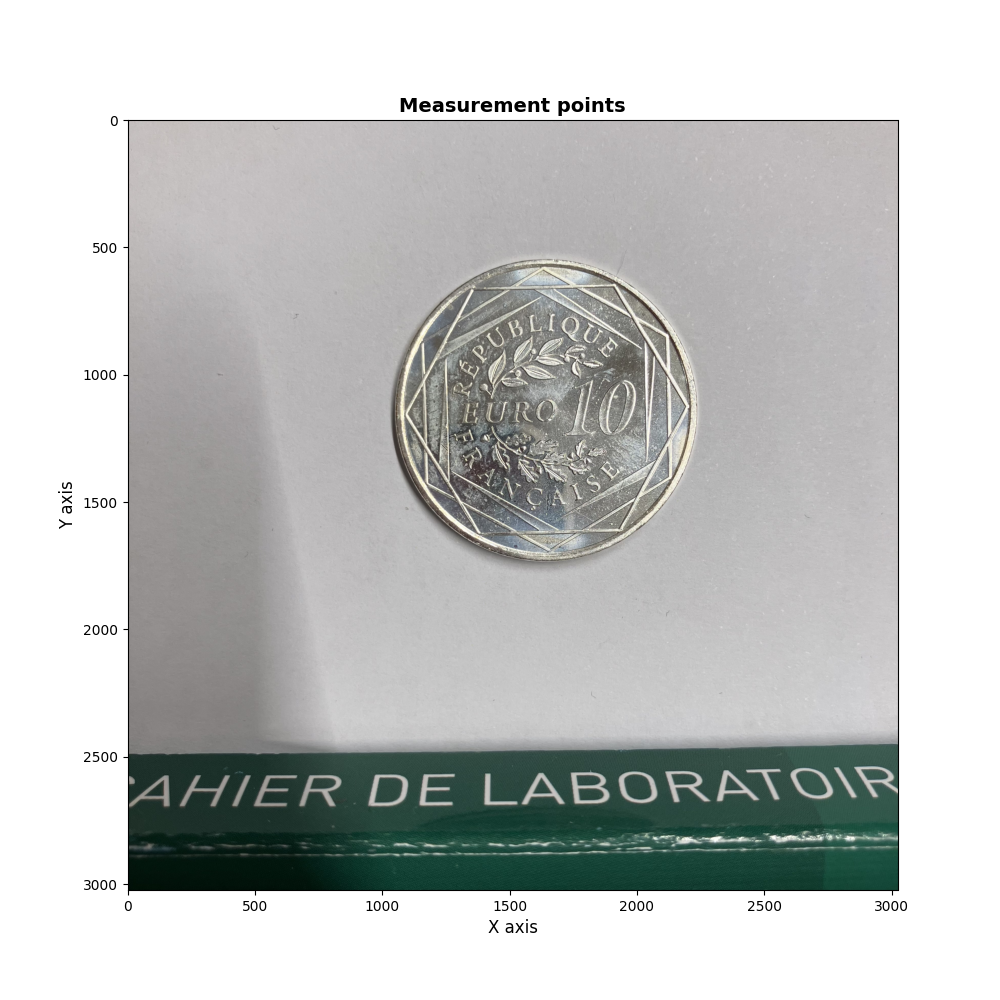

In [87]:
# %matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output



# Load image
img = plt.imread("/Users/nicolasgros/Desktop/HER-rev.jpeg")
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.set_title("Measurement points", fontsize=14, weight='bold')
ax.set_xlabel("X axis", fontsize=12)
ax.set_ylabel("Y axis", fontsize=12)



# Data storage
clicked_points = []
affine_matrices = []  # list of (system, matrix)
red_annotations = []
green_annotations = []
calibration_df = pd.DataFrame(columns=["label", "original_x", "original_y"])
measurement_df = pd.DataFrame(columns=["label", "original_x", "original_y"])
report_output = widgets.Output()



# Widgets
# Définition des boutons et cellules intéractives
click_mode_toggle = widgets.ToggleButton(value=False, description="Add Point (click)")
man_x_input = widgets.FloatText(description='X', step=0.1)
man_y_input = widgets.FloatText(description='Y', step=0.1)
alt_sys_dropdown = widgets.Dropdown(options=["None"], description='System')
man_add_btn = widgets.Button(description="Add Point")
save_btn = widgets.Button(description="Save Image + Report", button_style='info')
save_btn.on_click(lambda b: save_image_and_report("image_report.png"))

coord_input_fields = [widgets.HBox([widgets.FloatText(description=f'X{i+1}'),
                                    widgets.FloatText(description=f'Y{i+1}')]) for i in range(3)]
sys_input = widgets.Text(description='System', placeholder='e.g., µ-Raman')
affine_compute_btn = widgets.Button(description="Compute Transform")

clear_red_btn = widgets.Button(description="Clear Calib", button_style='danger')
clear_green_btn = widgets.Button(description="Clear Meas", button_style='success')
console_output = widgets.Output()



# Display widgets
# Définition de l'organisation visuelle des boutons
manual_input_layout = widgets.VBox([
    widgets.Label("Add a point using manual coordinates (image or transformed):"),
    widgets.HBox([man_add_btn, man_x_input, man_y_input, alt_sys_dropdown])
])
click_input_layout = widgets.VBox([
    widgets.Label("Add a point by clicking on the image:"),
    click_mode_toggle
])
affine_input_layout = widgets.VBox([
    widgets.Label("Enter measurement coordinates for the 3 selected points:"),
    widgets.HBox([
        affine_compute_btn,
        widgets.VBox(coord_input_fields),
        sys_input
    ])
])
clear_buttons_layout = widgets.HBox([clear_red_btn, clear_green_btn, save_btn])
widgets_layout = widgets.VBox([manual_input_layout, click_input_layout, affine_input_layout,
                                clear_buttons_layout])
full_layout = widgets.VBox([widgets_layout, report_output])  # Move report below the input panel
display(full_layout)



# Utility functions
# Définition des fonctions de modification de l'interface
def annotate_point(x, y, label, color='red', extra_labels=None):
    # Ajout d'un point sur l'image
    point_artist = ax.plot(x, y, '+', color=color)[0]
    label_text = ax.text(
        x + 20, y, label,
        color=color, fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.6)
    )
    if color == 'red':
        red_annotations.extend([point_artist, label_text])
    elif color == 'green':
        green_annotations.extend([point_artist, label_text])
    fig.canvas.draw()

def compute_affine_matrix(src_pts, dst_pts):
    # Calcul de la matrice pour la convertion entre systèmes de coordonnées
    A, B = [], []
    for (x, y), (u, v) in zip(src_pts, dst_pts):
        A.extend([[x, y, 1, 0, 0, 0], [0, 0, 0, x, y, 1]])
        B.extend([u, v])
    A = np.array(A)
    B = np.array(B)
    params = np.linalg.lstsq(A, B, rcond=None)[0]
    return np.array([[params[0], params[1], params[2]], [params[3], params[4], params[5]]])

def update_report():
    # Mise à jour du tableau récapitulatif des coordonnées
    with report_output:
        clear_output()
        dfs = []
        for df in [calibration_df, measurement_df]:
            if df.empty:
                continue
            expanded = df.copy()
            for system, matrix in affine_matrices:
                transformed = (matrix @ np.vstack([df["original_x"], df["original_y"], np.ones(len(df))])).T
                expanded[f"{system}_x"] = np.round(transformed[:, 0], 1)
                expanded[f"{system}_y"] = np.round(transformed[:, 1], 1)
            dfs.append(expanded)
        if dfs:
            display(pd.concat(dfs, ignore_index=True))



# Event Handlers
# Définition des réponses aux intéractions avec l'interface
def on_canvas_click(event):
    # Réponse à l'ajout d'un point cliqué sur l'image
    global calibration_df, measurement_df
    if not event.inaxes or not click_mode_toggle.value:
        return
    x, y = event.xdata, event.ydata
    with console_output:
        print(f"Clicked: ({x:.1f}, {y:.1f})")
    if len(clicked_points) < 3:
        label = f"CP{len(clicked_points) + 1}"
        clicked_points.append([x, y])
        annotate_point(x, y, label, 'red')
        calibration_df.loc[len(calibration_df)] = [label, x, y]
        update_report()
    else:
        label = f"MP{len(measurement_df) + 1}"
        labels = [f"Original: ({x:.1f}, {y:.1f})"]
        transformed = {}
        for system, matrix in affine_matrices:
            t = matrix @ np.array([x, y, 1])
            labels.append(f"{system}: ({t[0]:.0f}, {t[1]:.0f})")
            transformed[f"{system}_x"] = t[0]
            transformed[f"{system}_y"] = t[1]
        annotate_point(x, y, label, 'green')
        measurement_df.loc[len(measurement_df)] = {
            "label": label, "original_x": x, "original_y": y, **transformed
        }
        update_report()

def on_manual_add(b):
    # Réponse à l'ajout d'un point par ses coordonnées
    global calibration_df, measurement_df
    if alt_sys_dropdown.value != "None":
        system = alt_sys_dropdown.value
        matrix = next((m for s, m in affine_matrices if s == system), None)
        if matrix is None:
            with console_output:
                print(f"❌ No calibration found for system {system}.")
            return
        x_alt, y_alt = man_x_input.value, man_y_input.value
        p = np.array([x_alt, y_alt, 1])
        try:
            full_matrix = np.vstack([matrix, [0, 0, 1]])
            inv_matrix = np.linalg.inv(full_matrix)
            x, y, _ = inv_matrix @ p
        except Exception as e:
            with console_output:
                print(f"❌ Error inverting matrix: {e}")
            return
        with console_output:
            print(f"🔁 Transformed ({x_alt:.1f}, {y_alt:.1f}) in {system} → ({x:.1f}, {y:.1f}) in image")
    else:
        x, y = man_x_input.value, man_y_input.value

    if len(clicked_points) < 3:
        label = f"CP{len(clicked_points) + 1}"
        clicked_points.append([x, y])
        annotate_point(x, y, label, 'red')
        calibration_df.loc[len(calibration_df)] = [label, x, y]
    else:
        label = f"MP{len(measurement_df) + 1}"
        labels = [f"Original: ({x:.1f}, {y:.1f})"]
        transformed = {}
        for system, matrix in affine_matrices:
            t = matrix @ np.array([x, y, 1])
            labels.append(f"{system}: ({t[0]:.0f}, {t[1]:.0f})")
            transformed[f"{system}_x"] = t[0]
            transformed[f"{system}_y"] = t[1]
        annotate_point(x, y, label, 'green')
        measurement_df.loc[len(measurement_df)] = {
            "label": label, "original_x": x, "original_y": y, **transformed
        }
    update_report()

def on_compute_transform(b):
    # Réponse à l'application d'un nouveau système de coordonnées
    if len(clicked_points) != 3:
        with console_output:
            print("❌ Select exactly 3 image points first.")
        return
    try:
        real_world_coords = [[box.children[0].value, box.children[1].value] for box in coord_input_fields]
        matrix = compute_affine_matrix(clicked_points, real_world_coords)
        system = sys_input.value.strip()
        if not system:
            with console_output:
                print("❌ Please enter a system name.")
            return
        affine_matrices.append((system, matrix))
        alt_sys_dropdown.options = ["None"] + [s for s, _ in affine_matrices]
        with console_output:
            print(f"✅ Transformation matrix added for {system}:")
            print(matrix)
    except Exception as e:
        with console_output:
            print("❌ Error computing matrix:", e)

def clear_annotations(annotations):
    # Supprésion de l'affichage des points
    for artist in annotations:
        artist.remove()
    annotations.clear()
    fig.canvas.draw()

def on_clear_red(b):
    # Réponse à la suppression des points rouges
    global clicked_points, calibration_df
    clicked_points.clear()
    calibration_df = pd.DataFrame(columns=["label", "original_x", "original_y"])
    clear_annotations(red_annotations)
    update_report()

def on_clear_green(b):
    # Réponse à la suppression des points verts
    global measurement_df
    measurement_df = pd.DataFrame(columns=["label", "original_x", "original_y"])
    clear_annotations(green_annotations)
    update_report()

def save_image_and_report(filename="output.png"):
    if fig is None or (calibration_df.empty and measurement_df.empty):
        with console_output:
            print("❌ Nothing to save.")
        return

    # Get current view limits from the zoomed-in matplotlib interface
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create a new figure with 2 subplots: one for the image, one for the table
    save_fig, (ax_img, ax_table) = plt.subplots(1, 2, figsize=(16, 10), gridspec_kw={'width_ratios': [3, 2]})
    
    # Re-display the image with annotations
    ax_img.imshow(img)
    ax_img.set_xlim(xlim)
    ax_img.set_ylim(ylim)
    ax_img.set_title("Measurement Points", fontsize=14, weight='bold')
    ax_img.set_xlabel("X axis", fontsize=12)
    ax_img.set_ylabel("Y axis", fontsize=12)
    
    # Re-draw annotations
    for artist in red_annotations + green_annotations:
        if hasattr(artist, 'get_xydata'):
            ax_img.plot(*artist.get_xydata().T, '+', color='red')
        elif hasattr(artist, 'get_position'):
            pos = artist.get_position()
            ax_img.text(pos[0], pos[1], artist.get_text(), color=artist.get_color(),
                        fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.6))
    
    # Turn off axis for the table subplot
    ax_table.axis('off')

    # Build report DataFrame
    dfs = []
    for df in [calibration_df, measurement_df]:
        if df.empty:
            continue
        expanded = df.copy()
        for system, matrix in affine_matrices:
            transformed = (matrix @ np.vstack([df["original_x"], df["original_y"], np.ones(len(df))])).T
            expanded[f"{system}_x"] = np.round(transformed[:, 0], 1)
            expanded[f"{system}_y"] = np.round(transformed[:, 1], 1)
        dfs.append(expanded)
    
    if dfs:
        report_df = pd.concat(dfs, ignore_index=True)
        table = ax_table.table(cellText=report_df.values,
                               colLabels=report_df.columns,
                               loc='center',
                               cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.2, 1.2)
    
    save_fig.tight_layout()
    save_fig.savefig(filename, dpi=300)
    plt.close(save_fig)
    with console_output:
        print(f"✅ Saved to {filename}")



# Connect callbacks
# Définition des fonctions intéractives
fig.canvas.mpl_connect('button_press_event', on_canvas_click)
man_add_btn.on_click(on_manual_add)
affine_compute_btn.on_click(on_compute_transform)
clear_red_btn.on_click(on_clear_red)
clear_green_btn.on_click(on_clear_green)
